# Biochemical Kinetic Diagram Analysis

This is a basic overview of how to analyze kinetic diagrams using SciPy packages such as NumPy, NetworkX, MatPlotLib, and SymPy, as well as some code that utilizes the methods of Hill to generate diagrams and calculate state probabiliites analytically. 

## Diagram

The usual case is that someone will have constructed a diagram that represents the given system they want to model. A common starting point would then be a picture of their model, used to explain the processes and relationships between states. This is a diagram for a 6 state antiporter cycle, which is the example that will be used here:

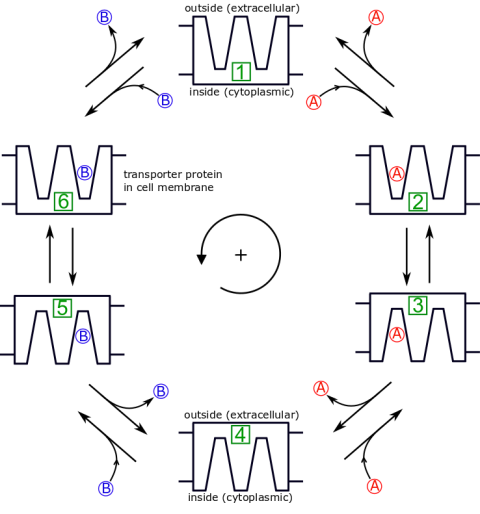

In this diagram there are 12 arrows, 2 between each pair of states. Each arrow represents its own process and thus has its own rate constant. These rate constants are normally indexed, where $k_{ij}$ respresents the rate going from state $i$ to state $j$. So for this diagram there are 12 rate constants: $k_{12}$, $k_{21}$, $k_{23}$, $k_{32}$, $k_{34}$, $k_{43}$, $k_{45}$, $k_{54}$, $k_{56}$, $k_{65}$, $k_{61}$, and $k_{16}$. These rate constants tell you the rate at which a given process is completed, and can be used to calculate state probabilities.

## NetworkX

As you may have guessed, this is where NetworkX comes in. NetworkX is a package that allows you to build and manipulate diagrams in Python. Building a graph of the six state model above is actually pretty simple. It is normally sufficient to define two functions: one to generate the positions of the nodes (states) and another to generate the edges (processes) between the states. 

In [1]:
import numpy as np

In [2]:
def generate_node_positions(center=[0, 0], radius=10):
    """
    Generates positions of nodes for a hexagon in the xy-plane

    Parameters
    ----------
    center : list
        Defines the center of the hexagon in the xy-plane
    radius : int
        The radius of the hexagon, from center to node
    """
    N = 6                                                       # number of states/nodes
    angle = np.pi*np.array([1/2, 13/6, 11/6, 3/2, 7/6, 5/6])    # Angles go counter clockwise
    array = np.zeros((N, 2))                                    # Empty 2D array of shape (6x2)
    for i in range(N):                                          # Creates hexagon of atoms in the xy-plane
        array[i, 0] = np.cos(angle[i])
        array[i, 1] = np.sin(angle[i])
    pos = {}                                                    # empty dict for positions to go in
    for i in range(N):
        pos[i] = array[i]*radius + center
    return pos

In [3]:
def generate_edges(G, rates, key='k'):
    G.add_weighted_edges_from([(0, 1, rates[0]),
                               (1, 0, rates[1]),
                               (1, 2, rates[2]),
                               (2, 1, rates[3]),
                               (2, 3, rates[4]),
                               (3, 2, rates[5]),
                               (3, 4, rates[6]),
                               (4, 3, rates[7]),
                               (4, 5, rates[8]),
                               (5, 4, rates[9]),
                               (5, 0, rates[10]),
                               (0, 5, rates[11])], weight=key)

Here the rates are being assigned to the attribute 'k' but you could also use the built-in 'weight' attribute that NetworkX MultiDiGraphs have. So how do I generate my diagram from here? Well, first I have to define my rate variables and put them into a list:

In [4]:
k12 = 2
k21 = 3
k23 = 5
k32 = 7
k34 = 11
k43 = 13
k45 = 17
k54 = 19
k56 = 23
k65 = 29
k61 = 31
k16 = 37
rates = [k12, k21, k23, k32, k34, k43, k45, k54, k56, k65, k61, k16]

I just assigned arbitrary rates for now, but they can always be updated or changed down the road. From here we need to use the above functions to generate our NetworkX graph, G:

In [5]:
import networkx as nx
G = nx.MultiDiGraph()
pos = generate_node_positions()
generate_edges(G, rates)

Yay! We generated our diagram! Where is it? Once you have your diagram generated, you can plot it using MatPlotLib:

In [6]:
import matplotlib.pyplot as plt

def plot_input_diagram(G, pos, save=None, path=None, date=None, run=None):
    fig1 = plt.figure(figsize=(4, 3), tight_layout=True)
    fig1.add_subplot(111)
    nx.draw_networkx_nodes(G, pos, node_size=500, nodelist=[i for i in range(G.number_of_nodes())], node_color='grey')
    nx.draw_networkx_edges(G, pos, width=4, arrow_style='->', arrowsize=15)
    labels = {}
    for i in range(G.number_of_nodes()):
        labels[i] = r"${}$".format(i+1)
    nx.draw_networkx_labels(G, pos, labels, font_size=16)

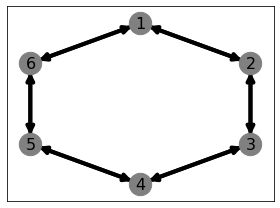

In [7]:
plot_input_diagram(G, pos)

As you can see, there are now 6 states (nodes) with 6 double-edged arrows between each consecutive pair, exactly like we wanted. To view all edge data: 

In [8]:
print(G.edges(data=True))

[(0, 1, {'k': 2}), (0, 5, {'k': 37}), (1, 0, {'k': 3}), (1, 2, {'k': 5}), (2, 1, {'k': 7}), (2, 3, {'k': 11}), (3, 2, {'k': 13}), (3, 4, {'k': 17}), (4, 3, {'k': 19}), (4, 5, {'k': 23}), (5, 4, {'k': 29}), (5, 0, {'k': 31})]


To create a list of all edges in your diagram:

In [9]:
edges = list(G.edges())
print("Edges:", edges)

Edges: [(0, 1), (0, 5), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (3, 4), (4, 3), (4, 5), (5, 4), (5, 0)]


You can iterate through this list to view edge data. These are 3D graphs, so the 3rd dimension for this case is just zero.

In [10]:
for e in edges:
    print("Edge: {}, Data: {}".format(e, G[e[0]][e[1]][0]))

Edge: (0, 1), Data: {'k': 2}
Edge: (0, 5), Data: {'k': 37}
Edge: (1, 0), Data: {'k': 3}
Edge: (1, 2), Data: {'k': 5}
Edge: (2, 1), Data: {'k': 7}
Edge: (2, 3), Data: {'k': 11}
Edge: (3, 2), Data: {'k': 13}
Edge: (3, 4), Data: {'k': 17}
Edge: (4, 3), Data: {'k': 19}
Edge: (4, 5), Data: {'k': 23}
Edge: (5, 4), Data: {'k': 29}
Edge: (5, 0), Data: {'k': 31}


If you want to see a specific weight just remember they are now index zero:

In [11]:
k12 == G[0][1][0]['k']
k43 == G[3][2][0]['k']

True

## Kinetic Diagram Analyzer

### Generating Partial Diagrams

Now that we have our NetworkX MultiDiGraph created, we can run it through the "Hill Biochemical Kinetic Diagram Analyzer" that will be referred to as "KDA" from now on. The first thing we need to do is create all of the partial diagrams associated with our MultiDiGraph, G:

In [12]:
import kinetic_diagram_analyzer as kda
partials = kda.generate_partial_diagrams(G)

Now plot all partial diagrams:

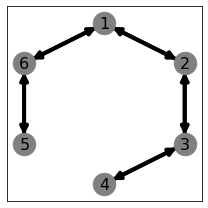

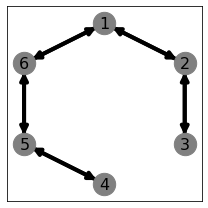

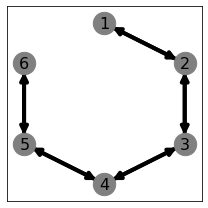

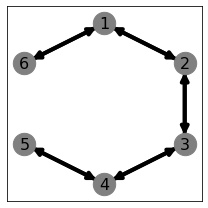

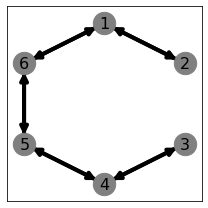

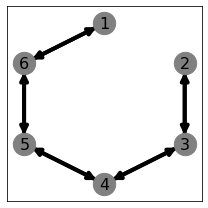

In [13]:
from plotting import plot_partials
plot_partials(partials, pos)

You will notice that there are a total of 6 unique diagrams here, where each one has a pair of directional edges missing between different pairs of nodes. This is exactly what we would expect for this case because a partial diagram has N-1 unique edges, where N is the number of states and a "unique edge" is just one of the unique pairs (i.e. there is only one unique edge between states 1 and 2 even though there are technically 2 edges between those states).

### Generating directional partial diagrams

With the set of partial diagrams above, we can generate all of the "directional partial diagrams", which are the set of diagrams that represent every combination of ways to get from state i to state j without creating a closed loop. Create your directional partial diagrams:

In [14]:
directional_partials = kda.generate_directional_partial_diagrams(partials)

Now plot all directional partial diagrams:

C:\Users\nikol\phy495\hill-biochemical-kinetic-diagram-analyzer\code\plotting.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1 = plt.figure(figsize=(3, 3), tight_layout=True)


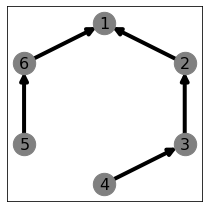

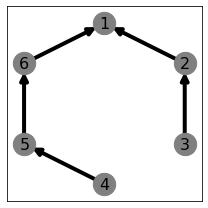

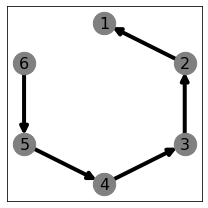

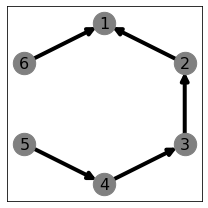

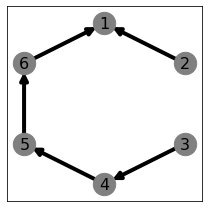

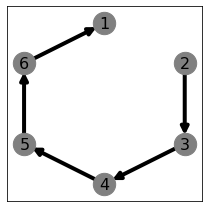

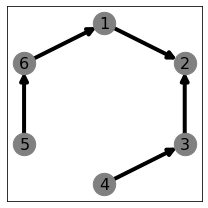

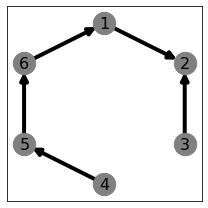

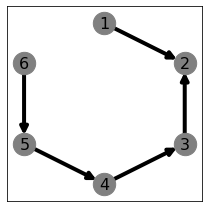

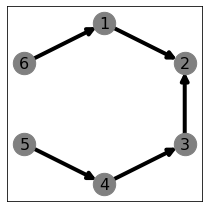

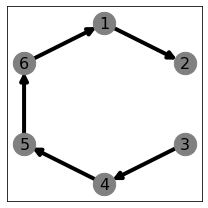

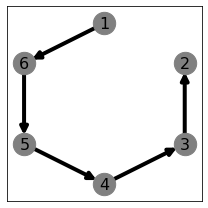

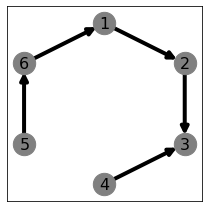

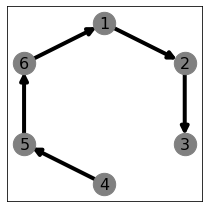

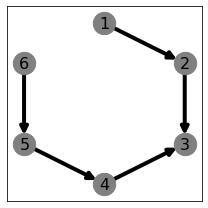

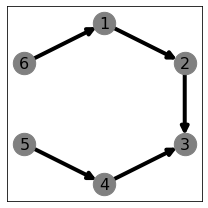

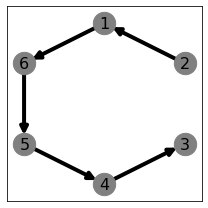

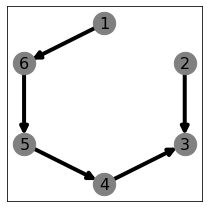

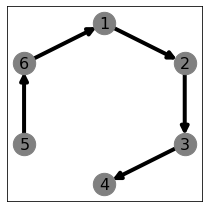

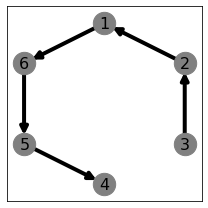

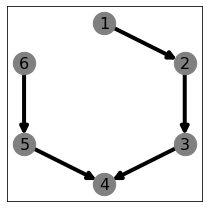

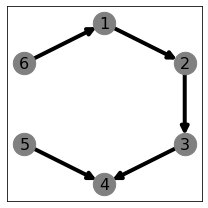

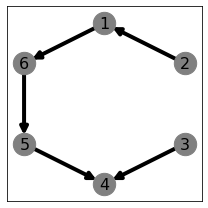

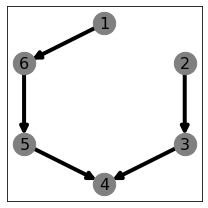

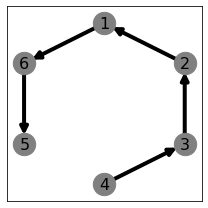

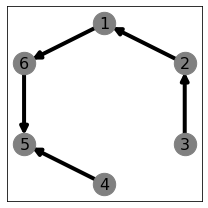

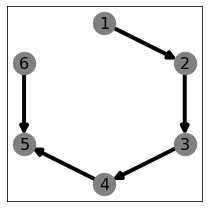

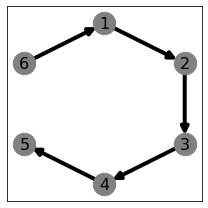

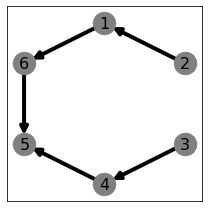

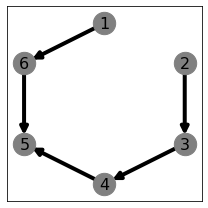

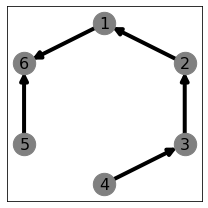

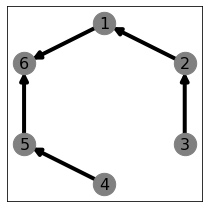

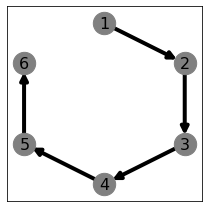

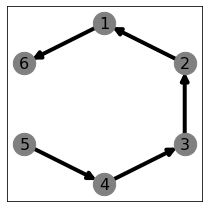

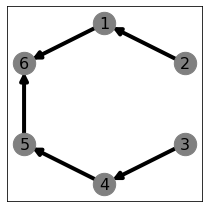

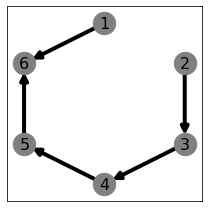

In [15]:
from plotting import plot_directional_partials
plot_directional_partials(directional_partials, pos)

If you count these up you will notice that there are 36 total directional partial diagrams associated with our MultiDiGraph, G. This makes perfect sense. For each partial diagram, there are 6 different states to "target", meaning there are 6 graphs to construct from each partial diagram, so 6 x 6 = 36. So what can we do with these? Well, according to Hill, we can use these graphs to calculate the probability of each state. Effectively each one of these graphs represents a value, and all we have to do is calculate what that value is and recombine them in the right way to calculate these values. Luckily KDA already has a built in function that does this for us:

In [16]:
state_probabilities = kda.calc_state_probabilities(G, directional_partials, key='k')

Now print the state probabilities:

In [93]:
for t, i in enumerate(state_probabilities):
    print("p{}: {:1.3f}".format(t+1, i))

p1: 0.132
p2: 0.190
p3: 0.180
p4: 0.176
p5: 0.173
p6: 0.148


With just a few function calls, we went from our graph G to having the state probabilities. But this was done with arbitrary rates, what if we want to calculate these state probabilities with different rates? We could of course go back and change the variable assignments, then run the code again with the new values. But if we do it that way, we are sort of limited to the analytic solution, and are not really able to manipulate it mathematically. The solution: SymPy. With the help of Sympy and KDA, we can generate the analytic functions that relate the rate constants to the state probabilities and manipulate them however we want. To start, we need to use KDA to generate the variable strings to input in to SymPy.

First we need to create a list of variables names (make sure they match your original variable assignments):

In [18]:
rate_names = ["k12", "k21", "k23", "k32", "k34", "k43", "k45", "k54", "k56", "k65", "k61", "k16"]

Now use these rate names, your input function G, your list of directional partial diagrams, your rates, and the key for your rates to generate the state multiplicity and normalization function strings:

In [19]:
state_mult_funcs, norm_func = kda.construct_string_funcs(G, directional_partials, rates, rate_names, key='k')

Now print one of the state multiplicity functions to get an idea of what they look like:

In [20]:
print("State 1 multiplicity function:")
print(state_mult_funcs[0])

State 1 multiplicity function:
k21*k32*k43*k56*k61+k21*k32*k45*k56*k61+k21*k32*k43*k54*k65+k21*k32*k43*k54*k61+k21*k34*k45*k56*k61+k23*k34*k45*k56*k61


Also print the normalization function, which is just the sum of all of the multiplicity functions:

In [21]:
print("Normalization function:")
print(norm_func)

Normalization function:
k21*k32*k43*k56*k61+k21*k32*k45*k56*k61+k21*k32*k43*k54*k65+k21*k32*k43*k54*k61+k21*k34*k45*k56*k61+k23*k34*k45*k56*k61+k12*k32*k43*k56*k61+k12*k32*k45*k56*k61+k12*k32*k43*k54*k65+k12*k32*k43*k54*k61+k12*k34*k45*k56*k61+k16*k32*k43*k54*k65+k12*k23*k43*k56*k61+k12*k23*k45*k56*k61+k12*k23*k43*k54*k65+k12*k23*k43*k54*k61+k16*k21*k43*k54*k65+k16*k23*k43*k54*k65+k12*k23*k34*k56*k61+k16*k21*k32*k54*k65+k12*k23*k34*k54*k65+k12*k23*k34*k54*k61+k16*k21*k34*k54*k65+k16*k23*k34*k54*k65+k16*k21*k32*k43*k65+k16*k21*k32*k45*k65+k12*k23*k34*k45*k65+k12*k23*k34*k45*k61+k16*k21*k34*k45*k65+k16*k23*k34*k45*k65+k16*k21*k32*k43*k56+k16*k21*k32*k45*k56+k12*k23*k34*k45*k56+k16*k21*k32*k43*k54+k16*k21*k34*k45*k56+k16*k23*k34*k45*k56


kda.construct_string_funcs() outputs 2 different strings. The first is a list of multiplicity functions for each state, and the second is the normalization factor for the multiplicity functions (normalized to 1). With this new collection of functions, we can create SymPy functions for our state probabilities:

In [22]:
from sympy import *
sympy_funcs = kda.construct_sympy_funcs(state_mult_funcs, norm_func)

Print the probability function for state 1:

In [23]:
sympy_funcs[0]

(k21*k32*k43*k54*k61 + k21*k32*k43*k54*k65 + k21*k32*k43*k56*k61 + k21*k32*k45*k56*k61 + k21*k34*k45*k56*k61 + k23*k34*k45*k56*k61)/(k12*k23*k34*k45*k56 + k12*k23*k34*k45*k61 + k12*k23*k34*k45*k65 + k12*k23*k34*k54*k61 + k12*k23*k34*k54*k65 + k12*k23*k34*k56*k61 + k12*k23*k43*k54*k61 + k12*k23*k43*k54*k65 + k12*k23*k43*k56*k61 + k12*k23*k45*k56*k61 + k12*k32*k43*k54*k61 + k12*k32*k43*k54*k65 + k12*k32*k43*k56*k61 + k12*k32*k45*k56*k61 + k12*k34*k45*k56*k61 + k16*k21*k32*k43*k54 + k16*k21*k32*k43*k56 + k16*k21*k32*k43*k65 + k16*k21*k32*k45*k56 + k16*k21*k32*k45*k65 + k16*k21*k32*k54*k65 + k16*k21*k34*k45*k56 + k16*k21*k34*k45*k65 + k16*k21*k34*k54*k65 + k16*k21*k43*k54*k65 + k16*k23*k34*k45*k56 + k16*k23*k34*k45*k65 + k16*k23*k34*k54*k65 + k16*k23*k43*k54*k65 + k16*k32*k43*k54*k65 + k21*k32*k43*k54*k61 + k21*k32*k43*k54*k65 + k21*k32*k43*k56*k61 + k21*k32*k45*k56*k61 + k21*k34*k45*k56*k61 + k23*k34*k45*k56*k61)

As you can see these functions are quite messy despite pretty printing, and even though they are simple rational functions they are not easy to write down. The nice thing about SymPy is it allows you to simplify these functions by relabeling variables and simplifying the expressions. For example, if you knew that $k_{23} = k_{32} = k_{56} = k_{65} = k_{conf}$, $k_{21} = k_{61} = k_{54} = k_{34} = k_{off}$,  and $k_{16} = k_{12} = k_{45} = k_{43} = k_{on}$. With this knowledge you could simplify these expressions considerably. Start by telling SymPy you want 3 new variables: 'k_conf', 'k_off', and 'k_on':

In [24]:
k_conf, k_off, k_on = symbols('k_conf k_off k_on')

Then tell SymPy you want to use the original variables you started with:

In [25]:
k12, k21, k23, k32, k34, k43, k45, k54, k56, k65, k61, k16 = symbols("k12 k21 k23 k32 k34 k43 k45 k54 k56 k65 k61 k16")

Now create a dictionary of substitutions where the keys are the original variables, and the values are the variables to be substituted:

In [26]:
sub_dict1 = {k23: k_conf, 
             k32: k_conf,
             k56: k_conf,
             k65: k_conf,
             k21: k_off,
             k61: k_off,
             k54: k_off,
             k34: k_off,
             k16: k_on,
             k12: k_on,
             k45: k_on,
             k43: k_on}

Now make your substitutions for every state probability function:

In [27]:
new_sympy_funcs1 = []
for func in sympy_funcs:
    new_sympy_funcs1.append(func.subs(sub_dict1))

Now print one of your functions to see how it changed:

In [28]:
new_sympy_funcs1[0]

(4*k_conf**2*k_off**2*k_on + 2*k_conf*k_off**3*k_on)/(8*k_conf**2*k_off**2*k_on + 16*k_conf**2*k_off*k_on**2 + 4*k_conf*k_off**3*k_on + 8*k_conf*k_off**2*k_on**2)

Now we can use SymPy to simplify this expression:

In [29]:
simplify(new_sympy_funcs1[0])

k_off/(2*(k_off + 2*k_on))

This is a much simpler expression to deal with. Lets simplify the rest of the expressions:

In [30]:
simplified_sympy_funcs1 = []
for func in new_sympy_funcs1:
    simplified_sympy_funcs1.append(simplify(func))

Now print them to see what variables are still relevant:

In [31]:
simplified_sympy_funcs1[0]

k_off/(2*(k_off + 2*k_on))

In [32]:
simplified_sympy_funcs1[1]

k_on/(2*(k_off + 2*k_on))

In [33]:
simplified_sympy_funcs1[2]

k_on/(2*(k_off + 2*k_on))

In [34]:
simplified_sympy_funcs1[3]

k_off/(2*(k_off + 2*k_on))

In [35]:
simplified_sympy_funcs1[4]

k_on/(2*(k_off + 2*k_on))

In [36]:
simplified_sympy_funcs1[5]

k_on/(2*(k_off + 2*k_on))

You will notice that with this variable change, the conformational change rate, $k_{conf}$, drops out completely. The probabilities are solely determined by the binding and unbinding rates. 

From here, we want to be able to plug in values to calculate our state probabilities. SymPy does allow you to plug in values to these expressions using the same substitution methods, but who wants to do all of that? Instead, KDA has a function that utilizes the SymPy "lambdify" function to turn these expressions into normal Python functions. Start by making a list of the relevant variable names:

In [37]:
var_names1 = ['k_off', 'k_on']

Now feed your SymPy functions and this variable name list into the KDA 'construct_lambdify_funcs' function:

In [38]:
python_prob_funcs1 = kda.construct_lambdify_funcs(simplified_sympy_funcs1, var_names1)

Make your variable value assignments:

In [39]:
k_off = 1e2
k_on = 2e3

Now calculate your state probabilities:

In [40]:
state_probs_lambdify1 = []
for func in python_prob_funcs1:
    state_probs_lambdify1.append(func(k_off, k_on))

Now print your state probabilities:

In [89]:
for t, prob in enumerate(state_probs_lambdify1):
    print("p{} = {:1.4f}".format(t+1, prob))

p1 = 0.0122
p2 = 0.2439
p3 = 0.2439
p4 = 0.0122
p5 = 0.2439
p6 = 0.2439


It's worth noting that once you have 'lambdified' your functions, there is no way to further manipulate them mathematically. Let's say you forgot that your binding rates, $k_{on}$, are actually concentration-dependent pseudo-first order rate constants and are unique. This means that all of the $k_{on}$ rates are transformed into $k_{on}$ times the concentration of either species A or B, either inside or outside. Let's assume that the concentration of species B is the same inside and outside of the cell. Start by feeding SymPy your new variables:

In [42]:
k_conf, k_off, k_on, A_in, A_out, B_conc = symbols('k_conf k_off k_on A_in A_out, B_conc')

Again, tell SymPy you want to use the variables you started with:

In [43]:
k12, k21, k23, k32, k34, k43, k45, k54, k56, k65, k61, k16 = symbols("k12 k21 k23 k32 k34 k43 k45 k54 k56 k65 k61 k16")

Now create your new substitution dictionary:

In [44]:
sub_dict2 = {k23: k_conf, 
             k32: k_conf,
             k56: k_conf,
             k65: k_conf,
             k21: k_off,
             k61: k_off,
             k54: k_off,
             k34: k_off,
             k43: k_on*A_in,
             k12: k_on*A_out,
             k45: k_on*B_conc,
             k16: k_on*B_conc}

Now convert the string multiplicity and normalization functions into SymPy state probability functions:

In [45]:
new_sympy_funcs2 = []
for func in sympy_funcs:
    new_sympy_funcs2.append(func.subs(sub_dict2))

In [46]:
new_sympy_funcs2[0]

(2*A_in*k_conf**2*k_off**2*k_on + A_in*k_conf*k_off**3*k_on + 2*B_conc*k_conf**2*k_off**2*k_on + B_conc*k_conf*k_off**3*k_on)/(4*A_in*A_out*k_conf**2*k_off*k_on**2 + 2*A_in*A_out*k_conf*k_off**2*k_on**2 + 4*A_in*B_conc*k_conf**2*k_off*k_on**2 + 2*A_in*B_conc*k_conf*k_off**2*k_on**2 + 2*A_in*k_conf**2*k_off**2*k_on + A_in*k_conf*k_off**3*k_on + 4*A_out*B_conc*k_conf**2*k_off*k_on**2 + 2*A_out*B_conc*k_conf*k_off**2*k_on**2 + 2*A_out*k_conf**2*k_off**2*k_on + A_out*k_conf*k_off**3*k_on + 4*B_conc**2*k_conf**2*k_off*k_on**2 + 2*B_conc**2*k_conf*k_off**2*k_on**2 + 4*B_conc*k_conf**2*k_off**2*k_on + 2*B_conc*k_conf*k_off**3*k_on)

Now use SymPy to simplify these expressions:

In [47]:
simplified_sympy_funcs2 = []
for func in new_sympy_funcs2:
    simplified_sympy_funcs2.append(simplify(func))

Now print the simplified functions:

In [48]:
simplified_sympy_funcs2[0]

k_off*(A_in + B_conc)/(2*A_in*A_out*k_on + 2*A_in*B_conc*k_on + A_in*k_off + 2*A_out*B_conc*k_on + A_out*k_off + 2*B_conc**2*k_on + 2*B_conc*k_off)

In [49]:
simplified_sympy_funcs2[1]

k_on*(2*A_in*A_out*k_conf + A_in*A_out*k_off + A_in*B_conc*k_conf + A_out*B_conc*k_conf + A_out*B_conc*k_off)/(4*A_in*A_out*k_conf*k_on + 2*A_in*A_out*k_off*k_on + 4*A_in*B_conc*k_conf*k_on + 2*A_in*B_conc*k_off*k_on + 2*A_in*k_conf*k_off + A_in*k_off**2 + 4*A_out*B_conc*k_conf*k_on + 2*A_out*B_conc*k_off*k_on + 2*A_out*k_conf*k_off + A_out*k_off**2 + 4*B_conc**2*k_conf*k_on + 2*B_conc**2*k_off*k_on + 4*B_conc*k_conf*k_off + 2*B_conc*k_off**2)

In [50]:
simplified_sympy_funcs2[2]

k_on*(2*A_in*A_out*k_conf + A_in*A_out*k_off + A_in*B_conc*k_conf + A_in*B_conc*k_off + A_out*B_conc*k_conf)/(4*A_in*A_out*k_conf*k_on + 2*A_in*A_out*k_off*k_on + 4*A_in*B_conc*k_conf*k_on + 2*A_in*B_conc*k_off*k_on + 2*A_in*k_conf*k_off + A_in*k_off**2 + 4*A_out*B_conc*k_conf*k_on + 2*A_out*B_conc*k_off*k_on + 2*A_out*k_conf*k_off + A_out*k_off**2 + 4*B_conc**2*k_conf*k_on + 2*B_conc**2*k_off*k_on + 4*B_conc*k_conf*k_off + 2*B_conc*k_off**2)

In [51]:
simplified_sympy_funcs2[3]

k_off*(A_out + B_conc)/(2*A_in*A_out*k_on + 2*A_in*B_conc*k_on + A_in*k_off + 2*A_out*B_conc*k_on + A_out*k_off + 2*B_conc**2*k_on + 2*B_conc*k_off)

In [52]:
simplified_sympy_funcs2[4]

B_conc*k_on*(A_in*k_conf + A_out*k_conf + A_out*k_off + 2*B_conc*k_conf + B_conc*k_off)/(4*A_in*A_out*k_conf*k_on + 2*A_in*A_out*k_off*k_on + 4*A_in*B_conc*k_conf*k_on + 2*A_in*B_conc*k_off*k_on + 2*A_in*k_conf*k_off + A_in*k_off**2 + 4*A_out*B_conc*k_conf*k_on + 2*A_out*B_conc*k_off*k_on + 2*A_out*k_conf*k_off + A_out*k_off**2 + 4*B_conc**2*k_conf*k_on + 2*B_conc**2*k_off*k_on + 4*B_conc*k_conf*k_off + 2*B_conc*k_off**2)

In [53]:
simplified_sympy_funcs2[5]

B_conc*k_on*(A_in*k_conf + A_in*k_off + A_out*k_conf + 2*B_conc*k_conf + B_conc*k_off)/(4*A_in*A_out*k_conf*k_on + 2*A_in*A_out*k_off*k_on + 4*A_in*B_conc*k_conf*k_on + 2*A_in*B_conc*k_off*k_on + 2*A_in*k_conf*k_off + A_in*k_off**2 + 4*A_out*B_conc*k_conf*k_on + 2*A_out*B_conc*k_off*k_on + 2*A_out*k_conf*k_off + A_out*k_off**2 + 4*B_conc**2*k_conf*k_on + 2*B_conc**2*k_off*k_on + 4*B_conc*k_conf*k_off + 2*B_conc*k_off**2)

Like before, use the KDA function to generate your lambdified functions so you can calculate your state probabilities with ease. Start by making a variable name list in the same order as above:

In [54]:
var_names2 = ['k_conf', 'k_off', 'k_on', 'A_in', 'A_out', 'B_conc']

Now construct you lambdified functions:

In [55]:
python_prob_funcs2 = kda.construct_lambdify_funcs(simplified_sympy_funcs2, var_names2)

Now make your value assignments:

In [94]:
k_on = 1e9      # units:  M^-1 s^-1
k_off = 1e6     # units:  s^-1
k_conf = 5e6    # units:  s^-1

A_conc = 1e-1   # total [A], in M
B_conc = 1e-7   # total [B], in M

A_in = A_conc
A_out = A_conc/10

Now plug your values in to calculate the state probabilities:

In [57]:
state_probs_lambdify2 = []
for func in python_prob_funcs2:
    state_probs_lambdify2.append(func(k_conf, k_off, k_on, A_in, A_out, B_conc))

Now print the state probabiliities:

In [87]:
for t, prob in enumerate(state_probs_lambdify2):
    print("p{} = {:1.6f}".format(t+1, prob))

p1 = 0.047393
p2 = 0.473931
p3 = 0.473931
p4 = 0.004739
p5 = 0.000002
p6 = 0.000003


Now that we have the simplified analytic functions to calculate the state probabilities of our original diagram, how do we verify these probabilities are correct? There are several methods, but perhaps the most straight-forward is by integration.

## ODE Integration

A common approach to this type of problem is to create a set of first order linear differential equations that correspond to each state, and integrate these equations. For the above simplified case, you end up with the following equations:

$$ \frac{d}{dt}p_1 = p_2 k_{off} + p_6 k_{off} - p_1 k'_{on}([A]_{out}) - p_1 k'_{on}([B]_{out})$$

$$ \frac{d}{dt}p_2 = p_3 k_{conf} + p_1 k'_{on}([A]_{out}) - p_2 k_{off} - p_2 k_{conf} $$

$$ \frac{d}{dt}p_3 = p_2 k_{conf} + p_4 k'_{on}([A]_{in}) - p_3 k_{off} - p_3 k_{conf} $$

$$ \frac{d}{dt}p_4 = p_3 k_{off} + p_5 k_{off} - p_4 k'_{on}([A]_{in}) - p_4 k'_{on}([B]_{in}) $$

$$ \frac{d}{dt}p_5 = p_6 k_{conf} + p_4 k'_{on}([B]_{in}) - p_5 k_{off} - p_5 k_{conf} $$

$$ \frac{d}{dt}p_6 = p_5 k_{conf} + p_1 k'_{on}([B]_{out}) - p_6 k_{off} - p_6 k_{conf} $$

These equations come from constructing a rate matrix that I will call the 'k-matrix' from now on. Your k-matrix is simply the matrix of all your rate constants, where the element $k_{ij}$ corresponds to the rate going from state $i$ to state $j$:

$$
K=
  \begin{bmatrix}
    k_{11} & k_{12} & k_{13} & k_{14} & k_{15} & k_{16}\\
    k_{21} & k_{22} & k_{23} & k_{24} & k_{25} & k_{26}\\
    k_{31} & k_{32} & k_{33} & k_{34} & k_{35} & k_{36}\\
    k_{41} & k_{42} & k_{43} & k_{44} & k_{45} & k_{46}\\
    k_{51} & k_{52} & k_{53} & k_{54} & k_{55} & k_{55}\\
    k_{61} & k_{62} & k_{63} & k_{64} & k_{65} & k_{65}
  \end{bmatrix}
$$

This is the general form, but if we plug in the values for our specific case, we get:

$$
K= 
  \begin{bmatrix}
    0 & k_{12}       & 0            & 0            & 0            & k_{16}      \\
    k_{21}       & 0 & k_{23}       & 0            & 0            & 0           \\
    0            & k_{32}       & 0 & k_{34}       & 0            & 0           \\
    0            & 0            & k_{43}       & 0 & k_{45}       & 0           \\
    0            & 0            & 0            & k_{54}       & 0 & k_{56}      \\
    k_{61}       & 0            & 0            & 0            & k_{65}       & 0   
  \end{bmatrix}
$$

From here, one would have to take the transpose of $K$ and set all of the diagonal terms equal to the negative of the sum of the elements in their row. This creates a matrix that can be multiplied by a state probability matrix to generate the differential equations above. 

$$
K_{converted}= 
  \begin{bmatrix}
    -(k_{12}+k_{16}) & k_{21}       & 0            & 0            & 0            & k_{61}      \\
    k_{12}       & -(k_{21}+k_{23}) & k_{32}       & 0            & 0            & 0           \\
    0            & k_{23}       & -(k_{32}+k_{34}) & k_{43}       & 0            & 0           \\
    0            & 0            & k_{34}       & -(k_{43}+k_{45}) & k_{54}       & 0           \\
    0            & 0            & 0            & k_{45}       & -(k_{54}+k_{56}) & k_{65}      \\
    k_{16}       & 0            & 0            & 0            & k_{56}       & -(k_{61}+k_{65})   
  \end{bmatrix}
$$

Now dot $K_{converted}$ with the state matrix to get the time-derivatives of the states:

$$
    \begin{bmatrix}
    \dot{p_1}\\
    \dot{p_2}\\
    \dot{p_3}\\
    \dot{p_4}\\
    \dot{p_5}\\
    \dot{p_6}
    \end{bmatrix}
=
    \begin{bmatrix}
    -(k_{12}+k_{16}) & k_{21}       & 0            & 0            & 0            & k_{61}      \\
    k_{12}       & -(k_{21}+k_{23}) & k_{32}       & 0            & 0            & 0           \\
    0            & k_{23}       & -(k_{32}+k_{34}) & k_{43}       & 0            & 0           \\
    0            & 0            & k_{34}       & -(k_{43}+k_{45}) & k_{54}       & 0           \\
    0            & 0            & 0            & k_{45}       & -(k_{54}+k_{56}) & k_{65}      \\
    k_{16}       & 0            & 0            & 0            & k_{56}       & -(k_{61}+k_{65})   
    \end{bmatrix}
    \begin{bmatrix}
    p_1\\
    p_2\\
    p_3\\
    p_4\\
    p_5\\
    p_6
    \end{bmatrix}
$$

Now this is level of depth is not required to move further, but it is important to know how to generate the equations associated with a given diagram. In order to integrate the FOLDE's above, we simply need to construct our k-matrix, our probability matrix, assign some integration parameters, and plug them into the KDA 'solve_ODE()' function. This function utilizes the SciPy.integrate.solve_ivp() function where the default integration algorithm is 'RK45' (https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html).

We can start with the same variable assignments above:

In [95]:
k_on = 1e9      # units:  M^-1 s^-1
k_off = 1e6     # units:  s^-1
k_conf = 5e6    # units:  s^-1

A_conc = 1e-1   # total [A], in M
B_conc = 1e-7   # total [B], in M

A_in = A_conc
A_out = A_conc/10

Now assign these to the rates in the same manner as the substitution dictionary: 

In [60]:
k23 = k_conf 
k32 = k_conf
k56 = k_conf
k65 = k_conf
k21 = k_off
k61 = k_off
k54 = k_off
k34 = k_off
k43 = k_on*A_in
k12 = k_on*A_out
k45 = k_on*B_conc
k16 = k_on*B_conc

Lastly, use these to construct your 'k-matrix' as a NumPy array:

In [61]:
K = np.array([[  0, k12,   0,   0,   0, k16],
              [k21,   0, k23,   0,   0,   0],
              [  0, k32,   0, k34,   0,   0],
              [  0,   0, k43,   0, k45,   0],
              [  0,   0,   0, k54,   0, k56],
              [k61,   0,   0,   0, k65,   0]])

Now that we have our k-matrix, we need to create our probability matrix. Start by making an array of arbitrary values:

In [62]:
P = np.array([1, 2, 3, 4, 5, 6]) 

Here I chose 6 different values as starting probabilities so it is easier to visualize when we plot the probabilities over time. But these probabilities still need to be normalized to 1, so let's go ahead and do that:

In [63]:
norm = P.sum(axis=0)
P = P/norm

Now we need to assign the other parameters for our integrator, namely, '$t_{max}$' and 'max_step'. 

$t_{max}$ is the amount of time (in seconds) the integrator will run, so this needs to be selected carefully. It is always easiest to start with a small value and run it for longer and longer intervals until the desired result is achieved. The desired result is the first derivative of the state probabilities with respect to time should be zero, in steady state. So once the state probabilities stop varying with time, this should be sufficient for an approximation. 

'max_step' is the maximum integration step size. The default integrator for SciPy.integrate.solve_ivp() is the 'RK45' algorithm, which will determine the step size on its own. Therefore setting 'max_step' equal to '$t_{max}$' will allow the algorithm to run as normal, but setting it to smaller values will ensure that it is giving sufficiently small time steps. 

Now let's assign these parameters:

In [64]:
t_max = 3e-5
max_step = t_max/1e3

With all of our inputs set, we just need to plug our parameters into kda.solve_ODE():

In [65]:
from kinetic_diagram_analyzer import solve_ODE
results = solve_ODE(P, K, t_max, max_step)   

The results contain the time-series of all 6 state probabilities as well as time and integrator information. We want to look at the overall behavior of the probabilities as a function of time, as well as the final state probability values for comparison to our lambdified function variants. Let's store the time-series of the state probabilities so we can compare them to the previously calculated values.

In [70]:
prob_time_series = results.y

Now let's calculate the relative error of the ODE probabilities compared to the lambdified function probabilties. First we have to append the probabilities at the last time step to a list:

In [77]:
ODE_final_probs = []
for state in prob_time_series:
    ODE_final_probs.append(state[-1])

Now calculate the relative error between the two data sets, where the lambdified values are considered the theoretical values:

In [75]:
rel_error = np.abs(np.array(state_probs_lambdify2) - np.array(ODE_final_probs))/np.array(state_probs_lambdify2)

Now print them with labels:

In [83]:
for t, error in enumerate(rel_error):
    print("State {} error: {:1.2e}".format(t+1, error))

State 1 error: 5.86e-16
State 2 error: 5.11e-14
State 3 error: 5.11e-14
State 4 error: 5.49e-16
State 5 error: 1.02e-08
State 6 error: 8.75e-09


You'll notice that all of these values are very close to each other, where the smaller probabilites have the largest relative errors. This makes sense because the smaller values have less significant figures and we are only keeping track of 16 decimal places at a time. 

Now let's plot the time series of the state probabilities to see if they had a sufficient amount of time to relax to the steady state probabilities:

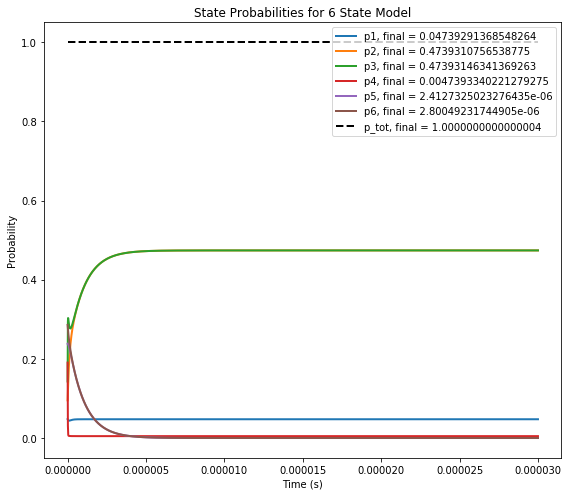

In [74]:
from plotting import plot_ODE_probs
plot_ODE_probs(results)

As you can see, this had a sufficient amount of time to relax to the steady-state. Normally you would want to plot these before you calculate error or do other analysis, but I chose to do it in this order because I had already checked that this would work before hand.

The probability integrator is sensitive to the integration time, $t_{max}$, such that too small of integration times don't allow the integrator to relax to the final values but integrating for too long accumulates error. SciPy.integrate.solve_ivp() allows the user to set a tolerance for the error accumulated per step which can minimize the error long term. But with KDA you don't have to worry about these things, it simply outputs the final functional form and you can manipulate it to your liking. 

Additionally, to calculate state probabilities using the ODE solver, you have to change the variables above and run the integrator again. The problem is that the integration time also depends on the order of the k-matrix values, meaning larger values require longer integration times and smaller values require shorter integration times. Therefore, if the k-matrix values are changed substantially, one would have to use a trial and error method to find a good $t_{max}$ value. The issue with this is that if this is the only method being used, there is no way to know for sure that the estimation of the final state probabilities is accurate because there is no reference values to check against. This process is much more involved than plugging in values to a lambdified function. 